This is my fairly quick attempt at the Titanic challenge from Kaggle.  If you haven't seen this before, the goal is essentially to try to come up with a means of predicting who survived given information like their gender, age, and what level of the ship they were on.  The first step is to import everything you'll need and then load the dataset.  

In [1]:
import pandas as pd
import seaborn as sb
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from sklearn import svm, preprocessing, cross_validation
import numpy as np
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

matplotlib.style.use( 'ggplot' )
sb.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

C:\Users\jfahe\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv('train.csv')

Now that we've imported everything we'll need, we need to first look at the dataset to try to get a feel for it and determine whether or not we need to do any cleaning.  I usually like to look at the first few rows of the set, check out the descriptive statistics for the numerical features, and then check out the distinct values for the categoricals.  

Right off the bat, we can see that given that the passenger names, ticket numbers, and cabins are all either distinct or missing a lot of values, we can probably leave them out of the analysis; it looks extremely likely that they would only contribute noise in our predictions.

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
print(set(train.Survived))
print(set(train.Pclass))
print(set(train.Sex))
print(set(train.Embarked))

{0, 1}
{1, 2, 3}
{'male', 'female'}
{'Q', nan, 'S', 'C'}


The describe function shows us that we're missing some values for age, but that definitely seems like something we should keep.  We'll get to that later.  As for the rest of the numerical columns, it looks like everything is both complete and has believable values (e.g. nobody paid a negative amount for their fare or was entered as 800 years old).

The categorical fields we're leaning towards keeping also look right for the most part, with the lone exception being Embarked, which has some blank entries.  We'll deal with that later too.

The next step is to start trying to assess whether or not we have any variables that might be contributing redundant information, as well as whether or not some variables have a clear connection to the survival outcome.  

In [6]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


Looking at the correlation matrix, it looks like most of our numerical features don't seem to be contributing redundant information.  It does look like fare and class have a noticeable relationship, as we could have guessed.  It also looks like the variable for siblings/spouses and parents/children do as well, which makes sense given that travelling with a sibling likely meant that given person was probably travelling with his or her family.  That's another thing we'll get to later.

Next, we're going to generate some visualizations.  I thought it would be a good idea to use the FacetGrid function in Seaborn to get a feel for whether or not sex and age have an interactive effect.  I also did the same for sex and fare.

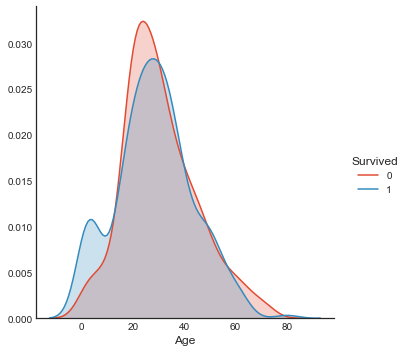

In [7]:
g = sb.FacetGrid(train,hue = 'Survived',size = 5,margin_titles=True)
g = g.map(sb.kdeplot,"Age",shade = True).add_legend()
plt.show()

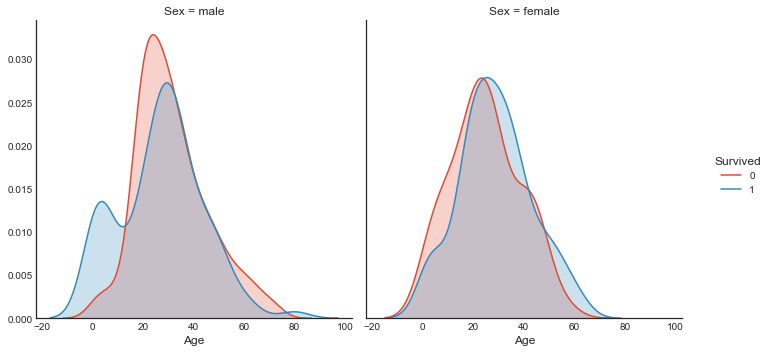

In [8]:
g = sb.FacetGrid(train,hue = 'Survived',col = 'Sex',size = 5,margin_titles=True)
g = g.map(sb.kdeplot,"Age",shade = True).add_legend()
plt.show()

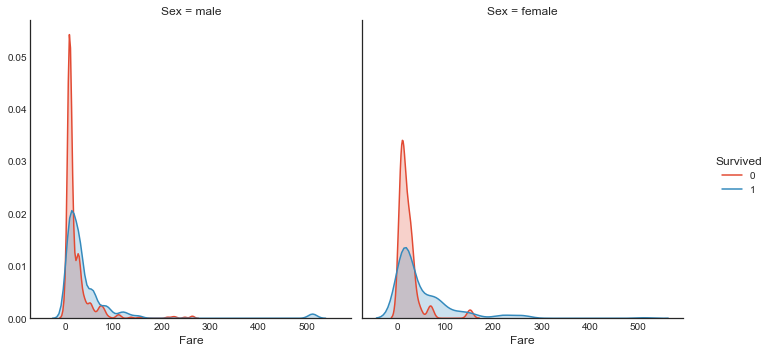

In [9]:
g = sb.FacetGrid(train,hue = 'Survived',col = 'Sex',size = 5,margin_titles=True)
g = g.map(sb.kdeplot,"Fare",shade = True).add_legend()
plt.show()

In [10]:
print(len(train[(train.Survived == 1)&(train.Sex == 'female')]))
print(len(train[(train.Survived == 1)&(train.Sex == 'male')]))
print(len(train[(train.Survived == 1)&(train.Fare > 80)]))

233
109
57


It certainly looks like there's a noticeable gender/age effect; any of us that saw the Titanic movie knows that the priorities for the lifeboats were women and children.  We can see that being a younger male (below about 14-15 years of age) greatly increased one's chance of survival.  Age doesn't seem to have as much of an effect for women, but women in general made up a noticeable majority of the survivors.

As for fare, it certainly looks as though those with a higher fare had a bit of an advantage.  

Now that we have a feel for our dataset, it's time to start preparing it for modeling.  I thought it'd be a good idea to add a field that combines the counters for parents/children with siblings/spouses to create a counter that basically represents family size.  If it doesn't help, most of the models will probably ignore it. 

In [11]:
train['family'] = train.Parch + train.SibSp

Next, we have to take care of a few things to put the training data in a format that the classifiers can actually use.  This means dropping the fields we decided earlier wouldn't matter (Passenger ID, Name, Ticket, and Cabin).  

It also means dealing with the empty age values; it's pretty obvious that age matters.  We could theoretically just drop the rows with null values, but given that we're already modeling a fairly small dataset, I think it makes more sense to impute those missing values with the mean age.  This allows us to keep the complete information from those rows without really hurting the model's ability to assess age as a factor.  

I also replaced the missing values for the Embarked column with 'Missing'; that will allow us to still use those rows while essentially adding another category for Embarked that shouldn't hurt the models' abilities to assess the effects for the other three categories.

In [12]:
reduced_train = train.drop(['PassengerId','Name','Ticket','Cabin'],1)

In [13]:
reduced_train.Age.fillna(reduced_train.Age.mean(),inplace = True)
reduced_train.Embarked.fillna('Missing',inplace = True)


Now we have to encode the dummy variables for the categoricals (Sex, P Class, and Embarked).

In [14]:
encoded_train = pd.get_dummies(reduced_train, columns = ['Sex','Pclass','Embarked'])
encoded_train.head()

,Survived,Age,SibSp,Parch,Fare,family,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Missing,Embarked_Q,Embarked_S
0,0,22.0,1,0,7.2500,1,0,1,0,0,1,0,0,0,1
1,1,38.0,1,0,71.2833,1,1,0,1,0,0,1,0,0,0
2,1,26.0,0,0,7.9250,0,1,0,0,0,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,1,0,1,0,0,0,0,0,1
4,0,35.0,0,0,8.0500,0,0,1,0,0,1,0,0,0,1


Now we're ready to convert the training data into an array format.  We start by doing this for the feature variables, meaning we drop Survived and scale them so we don't have features like Fare throwing everything off if it's excessively large.  

Then we convert the Survived column on its own into an array.

From there, we use the train_test_split function to assign our training and testing groups.  This is necessary to assess the effectiveness of our models before we try to use our final model on the testing set, which doesn't tell you whether or not someone survived.

In [15]:
X = np.array(encoded_train.drop(['Survived'],1))
X = preprocessing.scale(X)
y = np.array(encoded_train.Survived)

In [16]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y, test_size = 0.3)

Now we're ready to start creating models.  I tried a bunch of different methods just for fun to see which one worked the best. In order, we have SVM (Support Vector Machine), the Decision Tree Classifier, the MLP (Multilayer Perceptron), the Random Forest Classifier, and the K Nearest Neighbors classifier. 

In [17]:
clf = svm.SVC(kernel = 'linear')
clf.fit(X_train,y_train)
print(clf.score(X_test,y_test))

0.80223880597


In [18]:
dt = tree.DecisionTreeClassifier()
dt.fit(X_train,y_train)
print(dt.score(X_test,y_test))

0.791044776119


In [19]:
nn = MLPClassifier()
nn.fit(X_train,y_train)
print(nn.score(X_test,y_test))

0.828358208955


In [20]:
rf = RandomForestClassifier(n_estimators = 1000)
rf.fit(X_train,y_train)
print(rf.score(X_test,y_test))

0.832089552239


In [21]:
knn = KNeighborsClassifier(5)
knn.fit(X_train, y_train)
knn.score(X_test, y_test)

0.82462686567164178

At a glance, all of them did pretty well for a quick first try, with the Decision Tree being the only one that didn't clear 80% accuracy on the testing subset.  Given that we're using the Random Forest method anyways, I feel pretty comfortable ruling that one out. 

There are two things we need to do from here: first, we need to settle on an algorithm.  Then we need to decide what parameter settings appear to work best.  We could do this for all of the algorithms and decide from there, but for brevity's sake, I'm just going to settle on K Nearest Neighbors.  

So now my task is to try to pick the optimal number of "neighbors" for the algorithm to group by.  In our first attempt, we just went with five, but now we're going to make a plot out of the accuracies by the number of neighbors.  It's also worth noting that these accuracies are actually mean accuracies generated with the cross validation score function, which uses the entire set of training data and essentially gives all of the data a chance to be in the testing group.  This helps ensure that you didn't just happen to lump the least or most helpful data in either set and ideally gives you a bit clearer of an idea of how the model should perform going forward.  

In [22]:
#cv = cross_validation.cross_val_score(RandomForestClassifier(n_estimators = 100), X, y, cv=10)
cv = cross_validation.cross_val_score(KNeighborsClassifier(15), X, y, cv=10)
cv.mean()

0.80917035523777103

In [23]:
mean_list = []
for i in range(1,51):
    cv = cross_validation.cross_val_score(KNeighborsClassifier(i), X, y, cv=7)
    mean_list.append(cv.mean())

C:\Users\jfahe\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


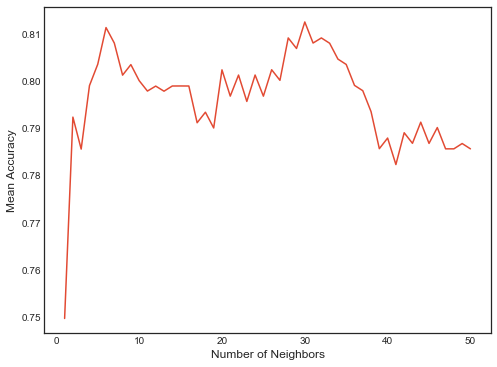

In [24]:
fig, ax = plt.subplots(1, 1)

x = np.linspace(1, 50,50) 

ax.plot(x, mean_list)

ax.set(xlabel='Number of Neighbors', ylabel='Mean Accuracy')
ax.legend()

plt.show()

As we would expect, we see an initial huge jump starting from 1.  This is because allowing the algorithm to separate the data into more groups gives it more wiggle room in its ability to classify appropriately.  Early on, the model tops out at 6 and then dips back down until it surges back up again as it gets towards 29, which gives us our best score before trending back down again as the model gets too complex. 

From here, we now have to create our final model and use it to generate predictions for the unlabeled testing set.

We haven't imported our testing data or prepped it yet, so let's take care of that first.  As before, we do need to repeat the process of checking for errors and imputing missing values.

In [25]:
test = pd.read_csv('test.csv')

In [26]:
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [27]:
print(set(test.Pclass))
print(set(test.Sex))
print(set(test.Embarked))

{1, 2, 3}
{'male', 'female'}
{'Q', 'S', 'C'}


The test set has the same issue with missing age values as well as a single missing fare value; to address this, I just imputed the means for both.  

Another issue that came up was that the test set didn't have any missing values in Embarked, which just meant that I needed to add a column full of zeroes for the Embarked_Missing dummy and rearrange the columns so it was in the same place as it was in the training set.  That last part is especially important because the model has no way of knowing which column is which once it's been converted into an array.  

In [28]:
test['family'] = test.Parch + test.SibSp

reduced_test = test.drop(['PassengerId','Name','Ticket','Cabin'],1)

reduced_test.Age.fillna(reduced_test.Age.mean(),inplace = True)
reduced_test.Fare.fillna(reduced_test.Fare.mean(),inplace = True)
reduced_test.Embarked.fillna('Missing',inplace = True)

In [29]:
encoded_test = pd.get_dummies(reduced_test, columns = ['Sex','Pclass','Embarked'])
encoded_test.head()

encoded_test['Embarked_Missing'] = 0.00

In [30]:
cols = encoded_test.columns.tolist()
cols = cols[0:11] + cols[13:] + cols[11:13]
cols

['Age',
 'SibSp',
 'Parch',
 'Fare',
 'family',
 'Sex_female',
 'Sex_male',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Embarked_C',
 'Embarked_Missing',
 'Embarked_Q',
 'Embarked_S']

In [31]:
encoded_test = encoded_test[cols]

In [32]:
encoded_test.describe()

,Age,SibSp,Parch,Fare,family,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Missing,Embarked_Q,Embarked_S
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.0,418.000000,418.000000
mean,30.272590,0.447368,0.392344,35.627188,0.839713,0.363636,0.636364,0.255981,0.222488,0.521531,0.244019,0.0,0.110048,0.645933
std,12.634534,0.896760,0.981429,55.840500,1.519072,0.481622,0.481622,0.436934,0.416416,0.500135,0.430019,0.0,0.313324,0.478803
min,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,30.272590,0.000000,0.000000,14.454200,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,1.000000
75%,35.750000,1.000000,0.000000,31.500000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.0,0.000000,1.000000
max,76.000000,8.000000,9.000000,512.329200,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


In [33]:
X_test = np.array(encoded_test)
X_test = preprocessing.scale(X_test)

In [34]:
final_df = pd.DataFrame(columns = ['PassengerId','Survived'])
final_df.PassengerId = test.PassengerId

In [35]:
knn = KNeighborsClassifier(29)
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=29, p=2,
           weights='uniform')

In [36]:
final_df['Survived'] = knn.predict(X_test)

In [37]:
final_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [38]:
print(len(final_df[final_df.Survived == 1]))
print(len(final_df[final_df.Survived == 0]))

112
306


Our dataframe appears to have the right values in place as well as what appears to be the right proportion of survivors, so it looks like we're ready to export our dataset into a CSV.

In [285]:
final_df.to_csv('predictions.csv', index = False)